#HMW7

In [ ]:
!pip install transformers

     |████████████████████████████████| 4.0 MB 3.8 MB/s 
     |████████████████████████████████| 77 kB 5.5 MB/s 
     |████████████████████████████████| 596 kB 29.7 MB/s 
     |████████████████████████████████| 895 kB 34.9 MB/s 
     |████████████████████████████████| 6.6 MB 34.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from transformers import BertTokenizer
from transformers import TFBertModel, TFBertForPreTraining
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!gdown 1lct2GyNPE2UwI8geGXRha6j1yU8tksSw
!gdown 13wDQLk8mXorxghxWFNfhWvXPWPPI27dL
!gdown 1St87-nfaqT5ZyiaDRY_NPy8PbRdTEPAY

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1lct2GyNPE2UwI8geGXRha6j1yU8tksSw
To: /content/train.csv
100% 20.1M/20.1M [00:00<00:00, 176MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=13wDQLk8mXorxghxWFNfhWvXPWPPI27dL
To: /content/valid.csv
100% 1.87M/1.87M [00:00<00:00, 158MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://d

In [ ]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
valid_df = pd.read_csv('valid.csv')

In [ ]:
def clean(data):
  tokens = data.split()
  translation_table = str.maketrans('', '', "\"#$%&'()*+-/:;<=>@[\]^_`{|}~?!.,")
  tokens = [w.translate(translation_table) for w in tokens]
  tokens = [word.lower() for word in tokens]
  return ' '.join(tokens)

In [ ]:
def cleaning_data(input_data):
  first_clean = []
  second_clean = []
  for index, row in input_data.iterrows():
    first_clean.append(clean(row['Input']))
    second_clean.append(clean(row['Output']))
  return first_clean,second_clean,input_data['Label'].tolist()

In [ ]:
train_df.head()

,Input,Output,Label
0,I'd like to start by talking about prices .,I'd be glad to answer any questions you may h...,1
1,Why ? Isn't it obvious ? First you impose way...,"I'm very sorry for that , but I sent you seve...",1
2,Those guys work at the same company and go to ...,Birds of a feather flock together .,1
3,It must be locked .,Let me ask the old woman in that reception of...,1
4,"Hey , Mary , nice to see you again . I heard y...",Where are you going now ?,0


In [ ]:
train_input,train_output,train_label = cleaning_data(train_df)
test_input,test_output,test_label = cleaning_data(test_df)
valid_input, valid_output,valid_label = cleaning_data(valid_df)

#**Q1**

In [ ]:
def bert_tokenize(tokenizer, input_data, output_data, labels):
  input_ids=[]
  attention_masks=[]

  for (input, output) in zip(input_data, output_data):
    bert_inp = tokenizer.encode_plus(input, output, add_special_tokens = True, max_length =64, pad_to_max_length = True, 
                                        return_attention_mask = True)
    input_ids.append(bert_inp['input_ids'])
    attention_masks.append(bert_inp['attention_mask'])

  input_ids = np.asarray(input_ids)
  attention_masks = np.array(attention_masks)
  labels = np.array(labels)
  return input_ids, attention_masks, labels

In [ ]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_inp, train_mask, train_label = bert_tokenize(bert_tokenizer, train_input, train_output, train_label)
test_inp, test_mask, test_label = bert_tokenize(bert_tokenizer, test_input, test_output, test_label)
valid_inp, valid_mask, valid_label = bert_tokenize(bert_tokenizer, valid_input, valid_output, valid_label)

In [ ]:
def build_model():
  SEQ_LEN = 64

  bert = TFBertModel.from_pretrained('bert-base-uncased')

  input_ids = tf.keras.layers.Input(shape=(SEQ_LEN,), name='input_ids', dtype='int32')
  mask = tf.keras.layers.Input(shape=(SEQ_LEN,), name='attention_mask', dtype='int32')

  embeddings = bert(input_ids, attention_mask=mask)[0]
  X = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x, axis=1))(embeddings)
  y = tf.keras.layers.Dense(1, activation='sigmoid', name='outputs')(X)

  bert_model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)
  return bert_model

In [ ]:
tf.keras.backend.clear_session()

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)

strategy = tf.distribute.experimental.TPUStrategy(resolver)

In [ ]:
with strategy.scope():
  bert_model = build_model()
  optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5,epsilon=1e-08)

  bert_model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

  bert_model.summary()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 64)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 64)]         0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 64,                                          

In [ ]:
cp_callback = ModelCheckpoint('/content/drive/MyDrive/bert-{epoch:03d}--{val_accuracy:03f}.h5', 
                             verbose=1, monitor='val_accuracy',save_best_only=True, 
                             save_weights_only=True, mode='max') 

In [ ]:
batch_size = 32
epoches = 7
history = bert_model.fit([train_inp, train_mask], train_label,
                       batch_size = batch_size,
                       epochs = epoches,
                       steps_per_epoch = int(np.ceil(train_inp.shape[0] / batch_size)),
                       validation_data = ([valid_inp, valid_mask],valid_label),
                       callbacks=[cp_callback])

Epoch 1/7


4754/4754 [==============================] - ETA: 0s - loss: 0.3596 - accuracy: 0.8314
Epoch 1: val_accuracy improved from -inf to 0.87841, saving model to /content/drive/MyDrive/HW-07/RahaAhmadi-bert-001--0.878413.h5
4754/4754 [==============================] - 487s 84ms/step - loss: 0.3596 - accuracy: 0.8314 - val_loss: 0.2836 - val_accuracy: 0.8784
Epoch 2/7
4754/4754 [==============================] - ETA: 0s - loss: 0.2017 - accuracy: 0.9174
Epoch 2: val_accuracy improved from 0.87841 to 0.88938, saving model to /content/drive/MyDrive/HW-07/RahaAhmadi-bert-002--0.889376.h5
4754/4754 [==============================] - 345s 73ms/step - loss: 0.2017 - accuracy: 0.9174 - val_loss: 0.2759 - val_accuracy: 0.8894
Epoch 3/7
4754/4754 [==============================] - ETA: 0s - loss: 0.1141 - accuracy: 0.9554
Epoch 3: val_accuracy did not improve from 0.88938
4754/4754 [==============================] - 344s 72ms/step - loss: 0.1141 - accuracy: 0.9554 - val_loss: 0.3442 - val_accuracy: 0.

In [ ]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

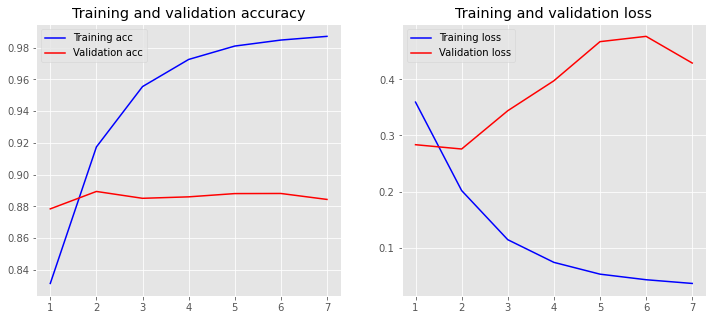

In [ ]:
plot_history(history)

In [ ]:
bert_model.load_weights('bert-002--0.889376.h5')

In [ ]:
bert_model.evaluate([test_inp, test_mask], test_label)

422/422 [==============================] - 11s 25ms/step - loss: 0.2673 - accuracy: 0.8887


[0.2672504782676697, 0.8887240290641785]

In [ ]:
preds = bert_model.predict([test_inp, test_mask])

In [ ]:
label_pred = np.where(preds > 0.5, 1, 0)

In [ ]:
count = 0
for i in range(len(test_label)):
  if label_pred[i][0] == test_label[i]:
    count += 1

accuracy = count / test_label.shape[0]
print('Number of true prediction: ', count)
print('Number of false prediction: ', test_label.shape[0] - count)
print('accuracy: ', accuracy)

Number of true prediction:  11980
Number of false prediction:  1500
accuracy:  0.8887240356083086


#**Q2**

In [ ]:
inputs = ['what do you do for your weekend?',
          'i am not quite sure yet . i like to go shopping .',
          'well , i am not sure what you are doing .',
          'i am not sure . i am not quite sure yet .',
          'well , i am not sure if you are interested , you would not have been fired .',
          'i am sorry , but i cannot . i have got a sore throat .',
          'oh , i see . but i have never been here before . i have been looking for a long time . it is really a nice neighborhood here .',
          'i really appreciate your help .',
          'thank you . i really appreciate your help .',
          'you are welcome . i hope you will enjoy your rest and hope to make up .']

outputs = ['i am not quite sure yet . i like to go shopping .',
           'well , i am not sure what you are doing .',
           'i am not sure . i am not quite sure yet .',
           'well , i am not sure if you are interested , you would not have been fired .',
           'i am sorry , but i cannot . i have got a sore throat .',
           'oh , i see . but i have never been here before . i have been looking for a long time . it is really a nice neighborhood here .',
           'i really appreciate your help .',
           'thank you . i really appreciate your help .',
           'you are welcome . i hope you will enjoy your rest and hope to make up .',
           'thank you . i will try to keep it to my li .']

In [ ]:
for (input, output) in zip(inputs, outputs):
  inp, mask, _ = bert_tokenize(bert_tokenizer, [input], [output], [])
  pred = bert_model.predict([inp, mask])
  is_next = np.where(pred > 0.5, 1, 0)[0][0]
  print(input)
  print(output)
  if is_next:
    print('IsNext.')
  else:
    print('NotNext.')

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


what do you do for your weekend?
i am not quite sure yet . i like to go shopping .
IsNext.
i am not quite sure yet . i like to go shopping .
well , i am not sure what you are doing .
IsNext.
well , i am not sure what you are doing .
i am not sure . i am not quite sure yet .
IsNext.
i am not sure . i am not quite sure yet .
well , i am not sure if you are interested , you would not have been fired .
IsNext.
well , i am not sure if you are interested , you would not have been fired .
i am sorry , but i cannot . i have got a sore throat .
NotNext.
i am sorry , but i cannot . i have got a sore throat .
oh , i see . but i have never been here before . i have been looking for a long time . it is really a nice neighborhood here .
NotNext.
oh , i see . but i have never been here before . i have been looking for a long time . it is really a nice neighborhood here .
i really appreciate your help .
IsNext.
i really appreciate your help .
thank you . i really appreciate your help .
IsNext.
thank y

#**Q3**

In [ ]:
inputs = ['how are you?',
          'what do you want to eat?',
          'what is your favorite color?',
          'what is your favorite color?',
          'Where have you been?',
          'Do you consider yourself a good mother?',
          'I have two nice sisters.']

outputs = ['Well, I love going to the cinema.',
           'I want to drink coffee.',
           'study.',
           'pink.',
           'i lived in England when i was at the conference . i always wanted to go out dancing.',
           'Yes , I am a very good mother and successful career woman.',
           'Is he very understanding and supportive?']

In [ ]:
for (input, output) in zip(inputs, outputs):
  inp, mask, _ = bert_tokenize(bert_tokenizer, [input], [output], [])
  pred = bert_model.predict([inp, mask])
  is_next = np.where(pred > 0.5, 1, 0)[0][0]
  print(input)
  print(output)
  if is_next:
    print('IsNext.')
  else:
    print('NotNext.')

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


how are you?
Well, I love going to the cinema.
NotNext.
what do you want to eat?
I want to drink coffee.
IsNext.
what is your favorite color?
study.
NotNext.
what is your favorite color?
pink.
IsNext.
Where have you been?
i lived in England when i was at the conference . i always wanted to go out dancing.
IsNext.
Do you consider yourself a good mother?
Yes , I am a very good mother and successful career woman.
IsNext.
I have two nice sisters.
Is he very understanding and supportive?
NotNext.


#**Q4**

In [ ]:
!gdown 1TtUSvIUjIF7mz49ZVTw7lt2fXQ726vaa

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1TtUSvIUjIF7mz49ZVTw7lt2fXQ726vaa
To: /content/SearchSpace.txt
100% 4.32M/4.32M [00:00<00:00, 174MB/s]


In [ ]:
data = []
with open('SearchSpace.txt') as f:
    for line in f:
      data.append(line.strip())

In [ ]:
result = []
for input in inputs:
  res = {}
  # only first 2000
  for output in data[:2000]:
    inp, mask, _ = bert_tokenize(bert_tokenizer, [input], [output], [])
    pred = bert_model.predict([inp, mask])
    res[output] = pred[0][0]
  best_pred = max(res, key=res.get)
  result.append((input, best_pred, res[best_pred]))


In [ ]:
for x in result:
  print('input: ', x[0])
  print('output: ', x[1])
  print('score: ', x[2])

input:  how are you?
output:  Just fine , thanks.And you ?
score:  0.9984804
input:  what do you want to eat?
output:  I don't know what I want to eat .
score:  0.9983571
input:  what is your favorite color?
output:  What kind of color tones do you like ?
score:  0.9986859
input:  what is your favorite color?
output:  What kind of color tones do you like ?
score:  0.9986859
input:  Where have you been?
output:  I went to the library and lost my bag .
score:  0.9964567
input:  Do you consider yourself a good mother?
output:  Not at all , but we don ’ t have a very traditional marriage either , so it suited us perfectly !
score:  0.9931359
input:  I have two nice sisters.
output:  What about your sister ?
score:  0.9988494
